In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import functools
import time
import os
from datasets import load_dataset
from collections import Counter
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import random

In [2]:
# Training Configuration
EPOCHS = 30              # Number of training epochs
BATCH_SIZE = 64          # Batch size
NUM_HEADS = 6            # Number of attention heads
NUM_LAYERS = 6           # Number of transformer layers
D_MODEL = 384            # Model dimensionality (multiple of NUM_HEADS)
D_FF = 1024              # Feed-forward network dimension
DROPOUT = 0.25           # Increased dropout rate (was 0.1)
LEARNING_RATE = 3e-4     # Base learning rate
MAX_LEN = 256            # Maximum sequence length
VOCAB_SIZE = 20000       # Vocabulary size
TRAIN_SPLIT = 0.7        # Percentage of data used for training
WEIGHT_DECAY = 1e-4      # Weight decay for regularization
MAX_GRAD_NORM = 1.0      # Gradient clipping norm
PATIENCE = 5            # Patience for early stopping
WARMUP_STEPS = 1000      # Steps for learning rate warmup
DATA_AUGMENTATION = True # Whether to use data augmentation
AUG_RATIO = 0.3          # Ratio of augmented data to add
SEED = 42  

In [3]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(SEED)

In [4]:
device = jax.devices()[0]
print(f"Using device: {device}")

def to_device(x):
    return jax.device_put(x, device)

Using device: cuda:0


In [5]:
def augment_text(text, p=0.15):
    """
    Simple text augmentation with word deletion, swapping, and duplication.
    
    Parameters:
    - text: original text string
    - p: probability of applying each transformation
    
    Returns:
    - augmented text string
    """
    tokens = text.lower().split()
    if len(tokens) <= 1:
        return text
    
    # Randomly drop words (with higher probability for stop words)
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'is', 'are', 'was', 'were', 'to', 'of', 'in', 'for', 'with'}
    tokens = [t for t in tokens if (t in stop_words and np.random.random() > p*1.5) or 
                                   (t not in stop_words and np.random.random() > p)]
    
    # Randomly swap adjacent words
    for i in range(len(tokens) - 1):
        if np.random.random() < p:
            tokens[i], tokens[i+1] = tokens[i+1], tokens[i]
    
    # Randomly duplicate words (less frequently)
    if len(tokens) > 3:
        for i in range(len(tokens)):
            if np.random.random() < p/3 and len(tokens[i]) > 2:  # Only duplicate non-trivial words
                tokens.insert(i, tokens[i])
    
    return " ".join(tokens)

In [6]:
def load_full_imdb_dataset(vocab_size=VOCAB_SIZE, max_len=MAX_LEN, train_split=TRAIN_SPLIT, 
                          augment=DATA_AUGMENTATION, aug_ratio=AUG_RATIO):
    """
    Load the IMDB dataset, apply a custom train/validation split, and augment data if requested.
    
    Parameters:
    - vocab_size: size of the vocabulary
    - max_len: maximum sequence length
    - train_split: portion of data used for training (e.g., 0.7 for 70%)
    - augment: whether to apply data augmentation
    - aug_ratio: ratio of augmented data to add
    
    Returns:
    - (train_inputs, train_labels): training data
    - (val_inputs, val_labels): validation data
    - vocab: vocabulary dictionary
    """
    print("Loading IMDB dataset...")
    dataset = load_dataset("imdb")
    
    # Combine train and test sets to resplit them
    all_texts = dataset['train']['text'] + dataset['test']['text']
    all_labels = dataset['train']['label'] + dataset['test']['label']
    
    # Create vocabulary based on all texts
    counter = Counter()
    for text in all_texts:
        counter.update(text.lower().split())

    most_common = counter.most_common(vocab_size - 2)
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
    vocab['<pad>'] = 0
    vocab['<unk>'] = 1

    def encode(text):
        tokens = text.lower().split()
        ids = [vocab.get(token, vocab['<unk>']) for token in tokens]
        return ids[:max_len] + [0] * (max_len - len(ids)) if len(ids) < max_len else ids[:max_len]
    
    # Split the data into training and validation sets (before augmentation)
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        all_texts, all_labels, train_size=train_split, random_state=SEED, stratify=all_labels
    )
    
    # Apply data augmentation to training set if requested
    if augment:
        print(f"Applying data augmentation to {aug_ratio*100:.0f}% of training data...")
        n_to_augment = int(len(train_texts) * aug_ratio)
        indices_to_augment = np.random.choice(len(train_texts), n_to_augment, replace=False)
        
        augmented_texts = []
        augmented_labels = []
        
        for i in indices_to_augment:
            augmented_texts.append(augment_text(train_texts[i]))
            augmented_labels.append(train_labels[i])
        
        train_texts = train_texts + augmented_texts
        train_labels = train_labels + augmented_labels
        
        print(f"Training data expanded from {len(train_texts)-len(augmented_texts)} to {len(train_texts)} examples with augmentation")
    
    # Encode all texts
    print("Encoding texts...")
    train_inputs = np.array([encode(t) for t in train_texts])
    train_labels = np.array(train_labels)
    val_inputs = np.array([encode(t) for t in val_texts])
    val_labels = np.array(val_labels)
    
    return (train_inputs, train_labels), (val_inputs, val_labels), vocab

def data_loader(inputs, labels, batch_size, shuffle=True, rng=None):
    n = len(inputs)
    idxs = np.arange(n)
    if shuffle:
        rng = np.random.default_rng(rng) if rng else np.random
        rng.shuffle(idxs)
    for i in range(0, n, batch_size):
        batch_idxs = idxs[i:min(i+batch_size, n)]
        yield inputs[batch_idxs], labels[batch_idxs]

In [7]:
# Learning rate schedule
def create_learning_rate_schedule(initial_lr=LEARNING_RATE, warmup_steps=WARMUP_STEPS, decay_rate=0.1, decay_steps=5000):
    """
    Create a learning rate schedule with warmup and decay.
    
    Parameters:
    - initial_lr: peak learning rate after warmup
    - warmup_steps: number of steps for linear warmup
    - decay_rate: factor by which to decay the learning rate
    - decay_steps: number of steps between decay applications
    
    Returns:
    - schedule function that takes a step and returns the learning rate
    """
    def schedule(step):
        # Linear warmup phase
        if step < warmup_steps:
            return initial_lr * (step / warmup_steps)
        
        # Decay phase
        decay_factor = decay_rate ** ((step - warmup_steps) / decay_steps)
        return initial_lr * decay_factor
    
    return schedule

In [8]:
# Model components
def init_token_embedding(vocab_size, d_model, key):
    return jax.random.normal(key, (vocab_size, d_model)) * 0.01

def get_positional_encoding(max_len, d_model):
    position = jnp.arange(max_len)[:, None]
    div_term = jnp.exp(jnp.arange(0, d_model, 2) * -(jnp.log(10000.0) / d_model))
    pe = jnp.zeros((max_len, d_model))
    pe = pe.at[:, 0::2].set(jnp.sin(position * div_term))
    pe = pe.at[:, 1::2].set(jnp.cos(position * div_term))
    return pe

def embed(inputs, token_embedding, positional_encoding):
    token_embeds = token_embedding[inputs]
    pos_embeds = positional_encoding[:inputs.shape[1]]
    pos_embeds = jnp.expand_dims(pos_embeds, 0)
    return token_embeds + pos_embeds

def create_padding_mask(inputs, pad_token=0):
    mask = (inputs == pad_token).astype(jnp.float32)
    return mask[:, None, None, :]

def dropout(x, dropout_rate, key, is_training=True):
    if not is_training or dropout_rate == 0.0:
        return x
    keep_prob = 1.0 - dropout_rate
    mask = jax.random.bernoulli(key, p=keep_prob, shape=x.shape)
    return (x * mask) / keep_prob



In [9]:
def init_multihead_attention_params(d_model, num_heads, key):
    keys = jax.random.split(key, 4)
    return {
        'W_q': jax.random.normal(keys[0], (d_model, d_model)) * 0.01,
        'W_k': jax.random.normal(keys[1], (d_model, d_model)) * 0.01,
        'W_v': jax.random.normal(keys[2], (d_model, d_model)) * 0.01,
        'W_o': jax.random.normal(keys[3], (d_model, d_model)) * 0.01,
    }

def multihead_attention(x, params, num_heads, mask=None, key=None, dropout_rate=DROPOUT, is_training=True):
    """
    Implementation of multi-head attention with increased dropout.
    """
    batch_size, seq_len, d_model = x.shape
    d_k = d_model // num_heads
    
    # Generate dropout keys if needed
    if key is not None and is_training:
        query_key, attn_key, output_key = jax.random.split(key, 3)
    else:
        query_key = attn_key = output_key = None
    
    # Linear projections with dropout
    Q = jnp.matmul(x, params['W_q'])
    K = jnp.matmul(x, params['W_k'])
    V = jnp.matmul(x, params['W_v'])
    
    # Apply input dropout (increased for regularization)
    if is_training and dropout_rate > 0 and query_key is not None:
        Q = dropout(Q, dropout_rate * 0.8, query_key, is_training)
    
    # Reshape to separate heads
    Q = Q.reshape(batch_size, seq_len, num_heads, d_k)
    K = K.reshape(batch_size, seq_len, num_heads, d_k)
    V = V.reshape(batch_size, seq_len, num_heads, d_k)
    
    # Transpose to (batch_size, num_heads, seq_len, d_k)
    Q = jnp.transpose(Q, (0, 2, 1, 3))
    K = jnp.transpose(K, (0, 2, 1, 3))
    V = jnp.transpose(V, (0, 2, 1, 3))
    
    # Calculate attention scores
    scores = jnp.matmul(Q, jnp.transpose(K, (0, 1, 3, 2))) / jnp.sqrt(d_k)
    
    # Apply mask if provided
    if mask is not None:
        expanded_mask = jnp.broadcast_to(mask, (batch_size, 1, seq_len, seq_len))
        expanded_mask = jnp.broadcast_to(expanded_mask, (batch_size, num_heads, seq_len, seq_len))
        scores = scores + (expanded_mask * -1e9)
    
    # Apply softmax to get attention weights
    attention_weights = jax.nn.softmax(scores, axis=-1)
    
    # Apply attention dropout (important for regularization)
    if is_training and dropout_rate > 0 and attn_key is not None:
        attention_weights = dropout(attention_weights, dropout_rate, attn_key, is_training)
    
    # Apply attention weights to values
    attention_output = jnp.matmul(attention_weights, V)
    
    # Transpose and reshape back to original dimensions
    attention_output = jnp.transpose(attention_output, (0, 2, 1, 3))
    attention_output = attention_output.reshape(batch_size, seq_len, d_model)
    
    # Final linear projection with dropout
    output = jnp.matmul(attention_output, params['W_o'])
    if is_training and dropout_rate > 0 and output_key is not None:
        output = dropout(output, dropout_rate, output_key, is_training)
    
    return output

In [10]:
# Transformer encoder layer
def init_transformer_encoder_layer_params(d_model, num_heads, d_ff, key):
    keys = jax.random.split(key, 6)
    return {
        'mha': init_multihead_attention_params(d_model, num_heads, keys[0]),
        'ffn_W1': jax.random.normal(keys[1], (d_model, d_ff)) * 0.01,
        'ffn_b1': jnp.zeros((d_ff,)),
        'ffn_W2': jax.random.normal(keys[2], (d_ff, d_model)) * 0.01,
        'ffn_b2': jnp.zeros((d_model,)),
        'norm1_scale': jnp.ones((d_model,)),
        'norm1_bias': jnp.zeros((d_model,)),
        'norm2_scale': jnp.ones((d_model,)),
        'norm2_bias': jnp.zeros((d_model,)),
    }

def layer_norm(x, scale, bias, eps=1e-6):
    mean = jnp.mean(x, axis=-1, keepdims=True)
    variance = jnp.var(x, axis=-1, keepdims=True)
    normalized = (x - mean) / jnp.sqrt(variance + eps)
    return scale * normalized + bias

def feed_forward(x, params):
    x = jnp.matmul(x, params['ffn_W1']) + params['ffn_b1']
    x = jax.nn.relu(x)
    x = jnp.matmul(x, params['ffn_W2']) + params['ffn_b2']
    return x

def transformer_encoder_layer(x, params, num_heads, mask=None, key=None, dropout_rate=DROPOUT, is_training=True):
    """
    Enhanced transformer encoder layer with increased regularization.
    """
    if key is not None:
        attn_key, ffn_key, drop1_key, drop2_key = jax.random.split(key, 4)
    else:
        attn_key = ffn_key = drop1_key = drop2_key = None

    # Attention sublayer with residual connection
    attn_output = multihead_attention(x, params['mha'], num_heads, mask, attn_key, dropout_rate, is_training)
    # Important: Add dropout to the residual path as well
    if is_training and dropout_rate > 0 and drop1_key is not None:
        x = dropout(x, dropout_rate * 0.5, drop1_key, is_training)  # Lower dropout on residual
    attn_output = layer_norm(x + attn_output, params['norm1_scale'], params['norm1_bias'])

    # Feed-forward sublayer with residual connection
    ffn_output = feed_forward(attn_output, params)
    if is_training and dropout_rate > 0 and ffn_key is not None:
        ffn_output = dropout(ffn_output, dropout_rate, ffn_key, is_training)
    # Also add dropout to this residual path
    if is_training and dropout_rate > 0 and drop2_key is not None:
        attn_output = dropout(attn_output, dropout_rate * 0.5, drop2_key, is_training)
    output = layer_norm(attn_output + ffn_output, params['norm2_scale'], params['norm2_bias'])

    return output


In [11]:
# Model
def init_transformer_model_params(vocab_size, max_len, d_model, num_heads, d_ff, num_layers, num_classes, key):
    keys = jax.random.split(key, num_layers + 3)
    return {
        'token_embedding': init_token_embedding(vocab_size, d_model, keys[0]),
        'positional_encoding': get_positional_encoding(max_len, d_model),
        'encoder_layers': [init_transformer_encoder_layer_params(d_model, num_heads, d_ff, keys[i+1]) 
                          for i in range(num_layers)],
        'classifier_W': jax.random.normal(keys[-2], (d_model, num_classes)) * 0.01,
        'classifier_b': jnp.zeros((num_classes,))
    }

def transformer_model(inputs, params, num_heads, mask=None, key=None, dropout_rate=DROPOUT, is_training=True):
    """
    Transformer model with enhanced regularization.
    """
    if key is not None:
        embed_key, encoder_key, final_key = jax.random.split(key, 3)
        encoder_keys = jax.random.split(encoder_key, len(params['encoder_layers']))
    else:
        embed_key = final_key = None
        encoder_keys = [None] * len(params['encoder_layers'])

    # Embedding layer with dropout
    x = embed(inputs, params['token_embedding'], params['positional_encoding'])
    if is_training and dropout_rate > 0 and embed_key is not None:
        x = dropout(x, dropout_rate, embed_key, is_training)

    # Apply encoder layers
    for idx, encoder_params in enumerate(params['encoder_layers']):
        x = transformer_encoder_layer(x, encoder_params, num_heads, mask, encoder_keys[idx], dropout_rate, is_training)

    # Global average pooling with dropout
    x = jnp.mean(x, axis=1)
    if is_training and dropout_rate > 0 and final_key is not None:
        x = dropout(x, dropout_rate, final_key, is_training)
    
    # Classification layer
    logits = jnp.matmul(x, params['classifier_W']) + params['classifier_b']
    return logits


In [12]:
# Loss and metrics
def cross_entropy_loss(logits, labels):
    one_hot = jax.nn.one_hot(labels, logits.shape[-1])
    log_probs = jax.nn.log_softmax(logits)
    loss = -jnp.sum(one_hot * log_probs, axis=-1)
    return jnp.mean(loss)

def accuracy_fn(logits, labels):
    preds = jnp.argmax(logits, axis=-1)
    return jnp.mean(preds == labels)

def precision_recall_f1(logits, labels):
    preds = jnp.argmax(logits, axis=-1)
    tp = jnp.sum((preds == 1) & (labels == 1))
    fp = jnp.sum((preds == 1) & (labels == 0))
    fn = jnp.sum((preds == 0) & (labels == 1))
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return precision, recall, f1

In [13]:
# Enhanced Adam optimizer with weight decay
def init_adam_optimizer(params, learning_rate=LEARNING_RATE, beta1=0.9, beta2=0.999, 
                        eps=1e-8, weight_decay=WEIGHT_DECAY):
    m = jax.tree_util.tree_map(lambda p: jnp.zeros_like(p), params)
    v = jax.tree_util.tree_map(lambda p: jnp.zeros_like(p), params)
    return {
        'm': m, 
        'v': v, 
        't': 0, 
        'lr': learning_rate, 
        'beta1': beta1, 
        'beta2': beta2, 
        'eps': eps,
        'weight_decay': weight_decay
    }

def adam_update(params, grads, opt_state, max_grad_norm=MAX_GRAD_NORM):
    """
    Adam optimizer update with weight decay and gradient clipping.
    Fixed to work with JAX JIT compilation.
    """
    # Gradient clipping - always apply but scale by max_grad_norm
    # Compute global gradient norm
    grad_norm = jnp.sqrt(
        sum(jnp.sum(g**2) for g in jax.tree_util.tree_leaves(grads))
    )
    # Clip gradients
    grads = jax.tree_util.tree_map(
        lambda g: g * jnp.minimum(1.0, max_grad_norm / (grad_norm + 1e-6)), 
        grads
    )
    
    # Apply weight decay - apply unconditionally but scale by weight_decay factor
    # This avoids the conditional that causes JIT issues
    weight_decay = opt_state['weight_decay']
    def apply_decay(p, g):
        # Only apply to weight matrices, not biases/vectors
        # is_matrix = jnp.size(p) > jnp.size(p.shape)  # Check if it's a matrix
        is_matrix = len(p.shape) > 1
        decay_factor = jnp.where(is_matrix, weight_decay, 0.0)
        return g + decay_factor * p
        
    grads = jax.tree_util.tree_map(apply_decay, params, grads)
    
    # Standard Adam update
    m, v, t = opt_state['m'], opt_state['v'], opt_state['t'] + 1
    beta1, beta2, lr, eps = opt_state['beta1'], opt_state['beta2'], opt_state['lr'], opt_state['eps']

    new_m = jax.tree_util.tree_map(lambda m, g: beta1 * m + (1 - beta1) * g, m, grads)
    new_v = jax.tree_util.tree_map(lambda v, g: beta2 * v + (1 - beta2) * (g ** 2), v, grads)

    m_hat = jax.tree_util.tree_map(lambda m: m / (1 - beta1 ** t), new_m)
    v_hat = jax.tree_util.tree_map(lambda v: v / (1 - beta2 ** t), new_v)

    new_params = jax.tree_util.tree_map(lambda p, m_h, v_h: p - lr * m_h / (jnp.sqrt(v_h) + eps), 
                                       params, m_hat, v_hat)
    
    return new_params, {
        'm': new_m, 
        'v': new_v, 
        't': t, 
        'lr': lr, 
        'beta1': beta1, 
        'beta2': beta2, 
        'eps': eps,
        'weight_decay': weight_decay
    }

In [14]:
# Training Step (JIT compiled)
@functools.partial(jax.jit, static_argnums=(3, 4))
def train_step(params, opt_state, batch, num_heads=NUM_HEADS, max_grad_norm=MAX_GRAD_NORM):
    """
    Training step with gradient clipping and additional regularization.
    """
    inputs, labels = batch
    key = jax.random.PRNGKey(0)  # Deterministic for JIT

    def loss_fn(p):
        logits = transformer_model(inputs, p, num_heads, mask=create_padding_mask(inputs), 
                               key=key, dropout_rate=DROPOUT, is_training=True)
        loss = cross_entropy_loss(logits, labels)
        return loss

    grads = jax.grad(loss_fn)(params)
    params, opt_state = adam_update(params, grads, opt_state, max_grad_norm)
    loss = loss_fn(params)
    
    # Calculate accuracy for monitoring
    logits = transformer_model(inputs, params, num_heads, mask=create_padding_mask(inputs), 
                           is_training=False)
    accuracy = accuracy_fn(logits, labels)
    
    return params, opt_state, loss, accuracy


In [15]:
# Save and Load
def save_model(params, filepath="transformer_params.pkl"):
    params_cpu = jax.device_get(params)
    with open(filepath, "wb") as f:
        pickle.dump(params_cpu, f)

def load_model(filepath="transformer_params.pkl"):
    with open(filepath, "rb") as f:
        return pickle.load(f)

# Save vocabulary to file
def save_vocab(vocab, filepath="transformer_vocab.pkl"):
    """Save vocabulary dictionary to file for later use in inference."""
    with open(filepath, "wb") as f:
        pickle.dump(vocab, f)

def load_vocab(filepath="transformer_vocab.pkl"):
    """Load vocabulary dictionary from file."""
    with open(filepath, "rb") as f:
        return pickle.load(f)

# Prediction function for inference
def predict_sentiment(text, params, vocab, max_len=MAX_LEN, num_heads=NUM_HEADS):
    """
    Predict sentiment for a given text using the trained transformer model.
    
    Parameters:
    - text: input text string
    - params: trained model parameters
    - vocab: vocabulary dictionary
    - max_len: maximum sequence length
    - num_heads: number of attention heads in the model
    
    Returns:
    - prediction: 0 for negative, 1 for positive
    - confidence: prediction confidence score
    - logits: raw model output
    """
    # Tokenize and encode the text
    tokens = text.lower().split()
    
    # Convert tokens to ids
    ids = [vocab.get(token, vocab['<unk>']) for token in tokens]
    
    # Pad or truncate
    if len(ids) < max_len:
        ids = ids + [vocab['<pad>']] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    
    # Convert to JAX array and send to device
    input_array = to_device(jnp.array([ids]))
    
    # Get prediction
    logits = transformer_model(
        input_array,
        params,
        num_heads,
        mask=create_padding_mask(input_array),
        is_training=False
    )
    
    # Convert to probabilities
    probs = jax.nn.softmax(logits)[0]
    prediction = int(jnp.argmax(probs))
    confidence = float(probs[prediction])
    
    return prediction, confidence, logits[0]


# Plotting function
def plot_training_curves(metrics, save_path="training_curves.png"):
    """
    Plot training and validation metrics.
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot losses
    ax1.plot(metrics['train_losses'], 'b-', label='Training Loss')
    ax1.plot(metrics['val_losses'], 'r-', label='Validation Loss')
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(metrics['train_accuracies'], 'b-', label='Training Accuracy')
    ax2.plot(metrics['val_accuracies'], 'r-', label='Validation Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # Plot precision and recall
    ax3.plot(metrics['val_precisions'], 'g-', label='Precision')
    ax3.plot(metrics['val_recalls'], 'm-', label='Recall')
    ax3.plot(metrics['val_f1s'], 'y-', label='F1 Score')
    ax3.set_title('Validation Precision-Recall Curves')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Score')
    ax3.legend()
    ax3.grid(True)
    
    # Plot learning rate
    if 'learning_rates' in metrics:
        ax4.plot(metrics['learning_rates'], 'g-')
        ax4.set_title('Learning Rate Schedule')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Learning Rate')
        ax4.set_yscale('log')
        ax4.grid(True)
    else:
        # Plot accuracy zoomed in to show detail
        ax4.plot(metrics['train_accuracies'], 'b-', label='Training Accuracy')
        ax4.plot(metrics['val_accuracies'], 'r-', label='Validation Accuracy')
        ax4.set_title('Accuracy Curves (Zoomed)')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Accuracy')
        if min(metrics['train_accuracies'] + metrics['val_accuracies']) > 0.5:
            ax4.set_ylim(0.5, 1.0)  # Zoom in if accuracies are above 0.5
        ax4.legend()
        ax4.grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

In [16]:
# Full training function with all regularization techniques
def train_transformer_on_imdb(num_epochs=EPOCHS, 
                             batch_size=BATCH_SIZE, 
                             d_model=D_MODEL, 
                             num_heads=NUM_HEADS, 
                             d_ff=D_FF, 
                             num_layers=NUM_LAYERS, 
                             base_lr=LEARNING_RATE,
                             train_split=TRAIN_SPLIT,
                             dropout_rate=DROPOUT,
                             weight_decay=WEIGHT_DECAY,
                             patience=PATIENCE,
                             max_grad_norm=MAX_GRAD_NORM):
    """
    Train a transformer model on the IMDB dataset with comprehensive anti-overfitting techniques.
    
    Techniques included:
    1. Increased dropout throughout the model
    2. Weight decay regularization
    3. Learning rate scheduling (warmup + decay)
    4. Early stopping with model checkpointing
    5. Gradient clipping
    6. Data augmentation
    7. Residual path dropout
    
    Parameters:
    - Standard model parameters plus regularization parameters
    
    Returns:
    - params: trained model parameters
    - vocab: vocabulary dictionary
    - metrics: various training metrics (losses, accuracies, etc.)
    """
    print("\n" + "="*80)
    print("TRANSFORMER TRAINING WITH ANTI-OVERFITTING TECHNIQUES")
    print("="*80 + "\n")
    
    # Report configuration
    print("Model Configuration:")
    print(f"- Epochs: {num_epochs}")
    print(f"- Batch size: {batch_size}")
    print(f"- Model dimension: d_model={d_model}, heads={num_heads}, layers={num_layers}, d_ff={d_ff}")
    print("\nRegularization Techniques:")
    print(f"- Dropout rate: {dropout_rate}")
    print(f"- Weight decay: {weight_decay}")
    print(f"- Early stopping patience: {patience}")
    print(f"- Gradient clipping norm: {max_grad_norm}")
    print(f"- Learning rate scheduling: Warmup + Decay (base_lr={base_lr})")
    print(f"- Data augmentation: {'Enabled' if DATA_AUGMENTATION else 'Disabled'}")
    print(f"- Training/Validation split: {train_split*100:.0f}%/{(1-train_split)*100:.0f}%")
    
    # Load and prepare data
    (train_inputs, train_labels), (val_inputs, val_labels), vocab = load_full_imdb_dataset(
        vocab_size=VOCAB_SIZE, 
        max_len=MAX_LEN,
        train_split=train_split
    )
    
    print(f"\nDataset loaded. Train samples: {len(train_inputs)}, Validation samples: {len(val_inputs)}")
    
    vocab_size = len(vocab)
    max_len = train_inputs.shape[1]
    num_classes = 2
    
    # Calculate total steps for progress and LR scheduling
    steps_per_epoch = len(train_inputs) // batch_size
    total_steps = steps_per_epoch * num_epochs
    print(f"Total training steps: {total_steps} ({steps_per_epoch} steps per epoch)")
    
    # Create learning rate schedule
    lr_schedule = create_learning_rate_schedule(
        initial_lr=base_lr,
        warmup_steps=WARMUP_STEPS,
        decay_rate=0.1,
        decay_steps=steps_per_epoch * 5  # Decay every 5 epochs
    )
    
    # Initialize model
    print("\nInitializing model...")
    key = jax.random.PRNGKey(SEED)
    params = to_device(init_transformer_model_params(vocab_size, max_len, d_model, num_heads, d_ff, num_layers, num_classes, key))
    opt_state = init_adam_optimizer(params, learning_rate=base_lr, weight_decay=weight_decay)

    # Initialize metrics tracking
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    learning_rates = []
    
    # Early stopping variables
    best_val_loss = float('inf')
    best_params = None
    patience_counter = 0
    
    # Setup for tracking training time
    total_start_time = time.time()
    print("\nStarting training...")

    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()
        print(f"\nEpoch {epoch}/{num_epochs}")
        
        # Update learning rate based on schedule
        current_step = (epoch - 1) * steps_per_epoch
        current_lr = lr_schedule(current_step)
        opt_state['lr'] = current_lr
        learning_rates.append(current_lr)
        
        print(f"Learning rate: {current_lr:.6f}")
        
        # Training phase
        epoch_loss = 0
        epoch_accuracy = 0
        n_batches = 0
        
        # Create data loader with batch indices
        batches = list(data_loader(train_inputs, train_labels, batch_size, shuffle=True, rng=epoch))
        
        # Training loop with progress bar
        train_pbar = tqdm(batches, desc=f"Training", unit="batch")
        for batch_inputs, batch_labels in train_pbar:
            # Convert numpy arrays to JAX arrays
            batch_inputs = to_device(jnp.array(batch_inputs))
            batch_labels = to_device(jnp.array(batch_labels))
            
            # Train step with JIT compilation
            params, opt_state, loss, accuracy = train_step(params, opt_state, (batch_inputs, batch_labels), num_heads, max_grad_norm)
            
            # Accumulate metrics
            epoch_loss += loss
            epoch_accuracy += accuracy
            n_batches += 1
            
            # Update progress bar
            train_pbar.set_postfix({"loss": f"{loss:.4f}", "acc": f"{accuracy:.4f}", "lr": f"{current_lr:.6f}"})

        # Calculate average training metrics
        avg_train_loss = epoch_loss / n_batches
        avg_train_acc = epoch_accuracy / n_batches
        
        # Store training metrics
        train_losses.append(float(avg_train_loss))
        train_accuracies.append(float(avg_train_acc))
        
        # Evaluation on validation set
        print("Running validation...")
        val_preds = []
        val_losses_list = []
        validation_size = len(val_inputs)
        
        # Process validation data in batches with progress bar
        val_steps = (validation_size + batch_size - 1) // batch_size  # Ceiling division
        val_pbar = tqdm(range(0, validation_size, batch_size), total=val_steps, desc="Validation", unit="batch")
        
        for i in val_pbar:
            end_idx = min(i + batch_size, validation_size)
            batch_inputs = val_inputs[i:end_idx]
            batch_labels = val_labels[i:end_idx]
            
            # Convert to device arrays
            batch_inputs = to_device(jnp.array(batch_inputs))
            batch_labels = to_device(jnp.array(batch_labels))
            
            # Get predictions (no dropout during evaluation)
            logits = transformer_model(
                batch_inputs, 
                params, 
                num_heads, 
                mask=create_padding_mask(batch_inputs),
                is_training=False
            )
            
            # Calculate validation loss
            val_loss = cross_entropy_loss(logits, batch_labels)
            val_losses_list.append(float(val_loss))
            
            # Move results back to CPU for collection
            val_preds.append(jax.device_get(logits))
            
            # Update validation progress bar
            val_pbar.set_postfix({"loss": f"{val_loss:.4f}"})
        
        # Calculate average validation loss
        avg_val_loss = sum(val_losses_list) / len(val_losses_list)
        val_losses.append(avg_val_loss)
        
        # Combine all predictions
        val_logits = np.vstack(val_preds)  # Using numpy's vstack for safety
        
        # Calculate metrics on CPU
        val_logits = jnp.array(val_logits)
        val_labels_array = jnp.array(val_labels)
        
        val_acc = float(accuracy_fn(val_logits, val_labels_array))
        precision, recall, f1 = precision_recall_f1(val_logits, val_labels_array)
        
        # Store metrics
        val_accuracies.append(val_acc)
        val_precisions.append(float(precision))
        val_recalls.append(float(recall))
        val_f1s.append(float(f1))
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_params = jax.tree_util.tree_map(lambda x: x, params)  # Deep copy
            patience_counter = 0
            save_model(params, filepath="transformer_imdb_best.pkl")
            print(f"✓ New best model saved (val_loss: {best_val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"! Validation loss did not improve. Patience: {patience_counter}/{patience}")
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        eta = epoch_time * (num_epochs - epoch)  # Estimated time remaining
        
        # Print epoch summary with timing information and metrics
        print(f"Epoch {epoch}/{num_epochs} completed in {epoch_time:.1f}s (ETA: {eta/60:.1f}m)")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
        
        # Check for early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch} epochs")
            break

    # Total training time
    total_time = time.time() - total_start_time
    print(f"\nTraining completed in {total_time/60:.2f} minutes")
    
    # Use best model from early stopping
    if best_params is not None:
        params = best_params
        print("Using best model from early stopping")
    
    # Final evaluation
    final_logits = []
    for i in range(0, validation_size, batch_size):
        end_idx = min(i + batch_size, validation_size)
        batch_inputs = val_inputs[i:end_idx]
        batch_inputs = to_device(jnp.array(batch_inputs))
        logits = transformer_model(batch_inputs, params, num_heads, 
                               mask=create_padding_mask(batch_inputs), is_training=False)
        final_logits.append(jax.device_get(logits))
    
    final_logits = np.vstack(final_logits)
    final_accuracy = float(accuracy_fn(jnp.array(final_logits), jnp.array(val_labels)))
    precision, recall, f1 = precision_recall_f1(jnp.array(final_logits), jnp.array(val_labels))
    
    print(f"\nFinal Evaluation Metrics:")
    print(f"Validation Accuracy: {final_accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Return all metrics for plotting
    metrics = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'val_precisions': val_precisions,
        'val_recalls': val_recalls,
        'val_f1s': val_f1s,
        'learning_rates': learning_rates
    }
    
    return params, vocab, metrics

In [17]:
print(f"Starting transformer training with anti-overfitting techniques")
print(f"Configuration:")
print(f"- Epochs: {EPOCHS}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Attention heads: {NUM_HEADS}")
print(f"- Transformer layers: {NUM_LAYERS}")
print(f"- Model dimension: {D_MODEL}")
print(f"- Feed-forward dimension: {D_FF}")
print(f"- Train/Val Split: {TRAIN_SPLIT*100:.0f}%/{(1-TRAIN_SPLIT)*100:.0f}%")
print(f"- Dropout: {DROPOUT}")
print(f"- Weight decay: {WEIGHT_DECAY}")

# Train model with specified configuration
params, vocab, metrics = train_transformer_on_imdb()

Starting transformer training with anti-overfitting techniques
Configuration:
- Epochs: 30
- Batch size: 64
- Attention heads: 6
- Transformer layers: 6
- Model dimension: 384
- Feed-forward dimension: 1024
- Train/Val Split: 70%/30%
- Dropout: 0.25
- Weight decay: 0.0001

TRANSFORMER TRAINING WITH ANTI-OVERFITTING TECHNIQUES

Model Configuration:
- Epochs: 30
- Batch size: 64
- Model dimension: d_model=384, heads=6, layers=6, d_ff=1024

Regularization Techniques:
- Dropout rate: 0.25
- Weight decay: 0.0001
- Early stopping patience: 5
- Gradient clipping norm: 1.0
- Learning rate scheduling: Warmup + Decay (base_lr=0.0003)
- Data augmentation: Enabled
- Training/Validation split: 70%/30%
Loading IMDB dataset...
Applying data augmentation to 30% of training data...
Training data expanded from 35000 to 45500 examples with augmentation
Encoding texts...

Dataset loaded. Train samples: 45500, Validation samples: 15000
Total training steps: 21300 (710 steps per epoch)

Initializing model..

Training:   0%|          | 0/711 [00:00<?, ?batch/s]

/tmp/ipykernel_24728/1430659263.py:38: DeprecationWarning: size requires ndarray or scalar arguments, got <class 'tuple'> at position 0. In a future JAX release this will be an error.
  is_matrix = jnp.size(p) > jnp.size(p.shape)  # Check if it's a matrix


Running validation...


Validation:   0%|          | 0/235 [00:00<?, ?batch/s]

✓ New best model saved (val_loss: 0.6976)
Epoch 1/30 completed in 456.5s (ETA: 220.6m)
Train Loss: 0.6943 | Train Acc: 0.4995
Val Loss: 0.6976 | Val Acc: 0.5000 | Precision: 0.5000 | Recall: 1.0000 | F1: 0.6667

Epoch 2/30
Learning rate: 0.000213


Training:   0%|          | 0/711 [00:00<?, ?batch/s]

Running validation...


Validation:   0%|          | 0/235 [00:00<?, ?batch/s]

✓ New best model saved (val_loss: 0.6928)
Epoch 2/30 completed in 80.0s (ETA: 37.4m)
Train Loss: 0.6931 | Train Acc: 0.5093
Val Loss: 0.6928 | Val Acc: 0.5109 | Precision: 0.5512 | Recall: 0.1169 | F1: 0.1929

Epoch 3/30
Learning rate: 0.000228


Training:   0%|          | 0/711 [00:00<?, ?batch/s]

Running validation...


Validation:   0%|          | 0/235 [00:00<?, ?batch/s]

! Validation loss did not improve. Patience: 1/5
Epoch 3/30 completed in 84.3s (ETA: 37.9m)
Train Loss: 0.6927 | Train Acc: 0.5100
Val Loss: 0.6954 | Val Acc: 0.5110 | Precision: 0.5327 | Recall: 0.1792 | F1: 0.2682

Epoch 4/30
Learning rate: 0.000144


Training:   0%|          | 0/711 [00:00<?, ?batch/s]

Running validation...


Validation:   0%|          | 0/235 [00:00<?, ?batch/s]

! Validation loss did not improve. Patience: 2/5
Epoch 4/30 completed in 79.7s (ETA: 34.5m)
Train Loss: 0.6920 | Train Acc: 0.5178
Val Loss: 0.7125 | Val Acc: 0.5118 | Precision: 0.5470 | Recall: 0.1373 | F1: 0.2195

Epoch 5/30
Learning rate: 0.000091


Training:   0%|          | 0/711 [00:00<?, ?batch/s]

Running validation...


Validation:   0%|          | 0/235 [00:00<?, ?batch/s]

✓ New best model saved (val_loss: 0.5173)
Epoch 5/30 completed in 82.3s (ETA: 34.3m)
Train Loss: 0.6347 | Train Acc: 0.6073
Val Loss: 0.5173 | Val Acc: 0.8186 | Precision: 0.8212 | Recall: 0.8145 | F1: 0.8179

Epoch 6/30
Learning rate: 0.000057


Training:   0%|          | 0/711 [00:00<?, ?batch/s]

Running validation...


Validation:   0%|          | 0/235 [00:00<?, ?batch/s]

! Validation loss did not improve. Patience: 1/5
Epoch 6/30 completed in 83.6s (ETA: 33.4m)
Train Loss: 0.3582 | Train Acc: 0.8448
Val Loss: 0.5202 | Val Acc: 0.8341 | Precision: 0.7791 | Recall: 0.9325 | F1: 0.8489

Epoch 7/30
Learning rate: 0.000036


Training:   0%|          | 0/711 [00:00<?, ?batch/s]

Running validation...


Validation:   0%|          | 0/235 [00:00<?, ?batch/s]

! Validation loss did not improve. Patience: 2/5
Epoch 7/30 completed in 80.2s (ETA: 30.7m)
Train Loss: 0.2951 | Train Acc: 0.8769
Val Loss: 0.5587 | Val Acc: 0.8433 | Precision: 0.7881 | Recall: 0.9389 | F1: 0.8570

Epoch 8/30
Learning rate: 0.000023


Training:   0%|          | 0/711 [00:00<?, ?batch/s]

Running validation...


Validation:   0%|          | 0/235 [00:00<?, ?batch/s]

✓ New best model saved (val_loss: 0.4479)
Epoch 8/30 completed in 83.4s (ETA: 30.6m)
Train Loss: 0.2700 | Train Acc: 0.8906
Val Loss: 0.4479 | Val Acc: 0.8644 | Precision: 0.8819 | Recall: 0.8415 | F1: 0.8612

Epoch 9/30
Learning rate: 0.000014


Training:   0%|          | 0/711 [00:00<?, ?batch/s]

Running validation...


Validation:   0%|          | 0/235 [00:00<?, ?batch/s]

! Validation loss did not improve. Patience: 1/5
Epoch 9/30 completed in 83.5s (ETA: 29.2m)
Train Loss: 0.2556 | Train Acc: 0.8980
Val Loss: 0.4757 | Val Acc: 0.8683 | Precision: 0.8557 | Recall: 0.8860 | F1: 0.8706

Epoch 10/30
Learning rate: 0.000009


Training:   0%|          | 0/711 [00:00<?, ?batch/s]

Running validation...


Validation:   0%|          | 0/235 [00:00<?, ?batch/s]

! Validation loss did not improve. Patience: 2/5
Epoch 10/30 completed in 78.2s (ETA: 26.1m)
Train Loss: 0.2456 | Train Acc: 0.9020
Val Loss: 0.4634 | Val Acc: 0.8694 | Precision: 0.8489 | Recall: 0.8988 | F1: 0.8731

Epoch 11/30
Learning rate: 0.000006


Training:   0%|          | 0/711 [00:00<?, ?batch/s]

Running validation...


Validation:   0%|          | 0/235 [00:00<?, ?batch/s]

! Validation loss did not improve. Patience: 3/5
Epoch 11/30 completed in 83.6s (ETA: 26.5m)
Train Loss: 0.2403 | Train Acc: 0.9039
Val Loss: 0.5133 | Val Acc: 0.8649 | Precision: 0.8302 | Recall: 0.9176 | F1: 0.8717

Epoch 12/30
Learning rate: 0.000004


Training:   0%|          | 0/711 [00:00<?, ?batch/s]

Running validation...


Validation:   0%|          | 0/235 [00:00<?, ?batch/s]

! Validation loss did not improve. Patience: 4/5
Epoch 12/30 completed in 83.7s (ETA: 25.1m)
Train Loss: 0.2370 | Train Acc: 0.9056
Val Loss: 0.5006 | Val Acc: 0.8674 | Precision: 0.8376 | Recall: 0.9116 | F1: 0.8730

Epoch 13/30
Learning rate: 0.000002


Training:   0%|          | 0/711 [00:00<?, ?batch/s]

Running validation...


Validation:   0%|          | 0/235 [00:00<?, ?batch/s]

! Validation loss did not improve. Patience: 5/5
Epoch 13/30 completed in 79.4s (ETA: 22.5m)
Train Loss: 0.2353 | Train Acc: 0.9067
Val Loss: 0.5171 | Val Acc: 0.8639 | Precision: 0.8266 | Recall: 0.9209 | F1: 0.8712

Early stopping triggered after 13 epochs

Training completed in 23.97 minutes
Using best model from early stopping

Final Evaluation Metrics:
Validation Accuracy: 0.8644
Precision: 0.8819, Recall: 0.8415, F1 Score: 0.8612


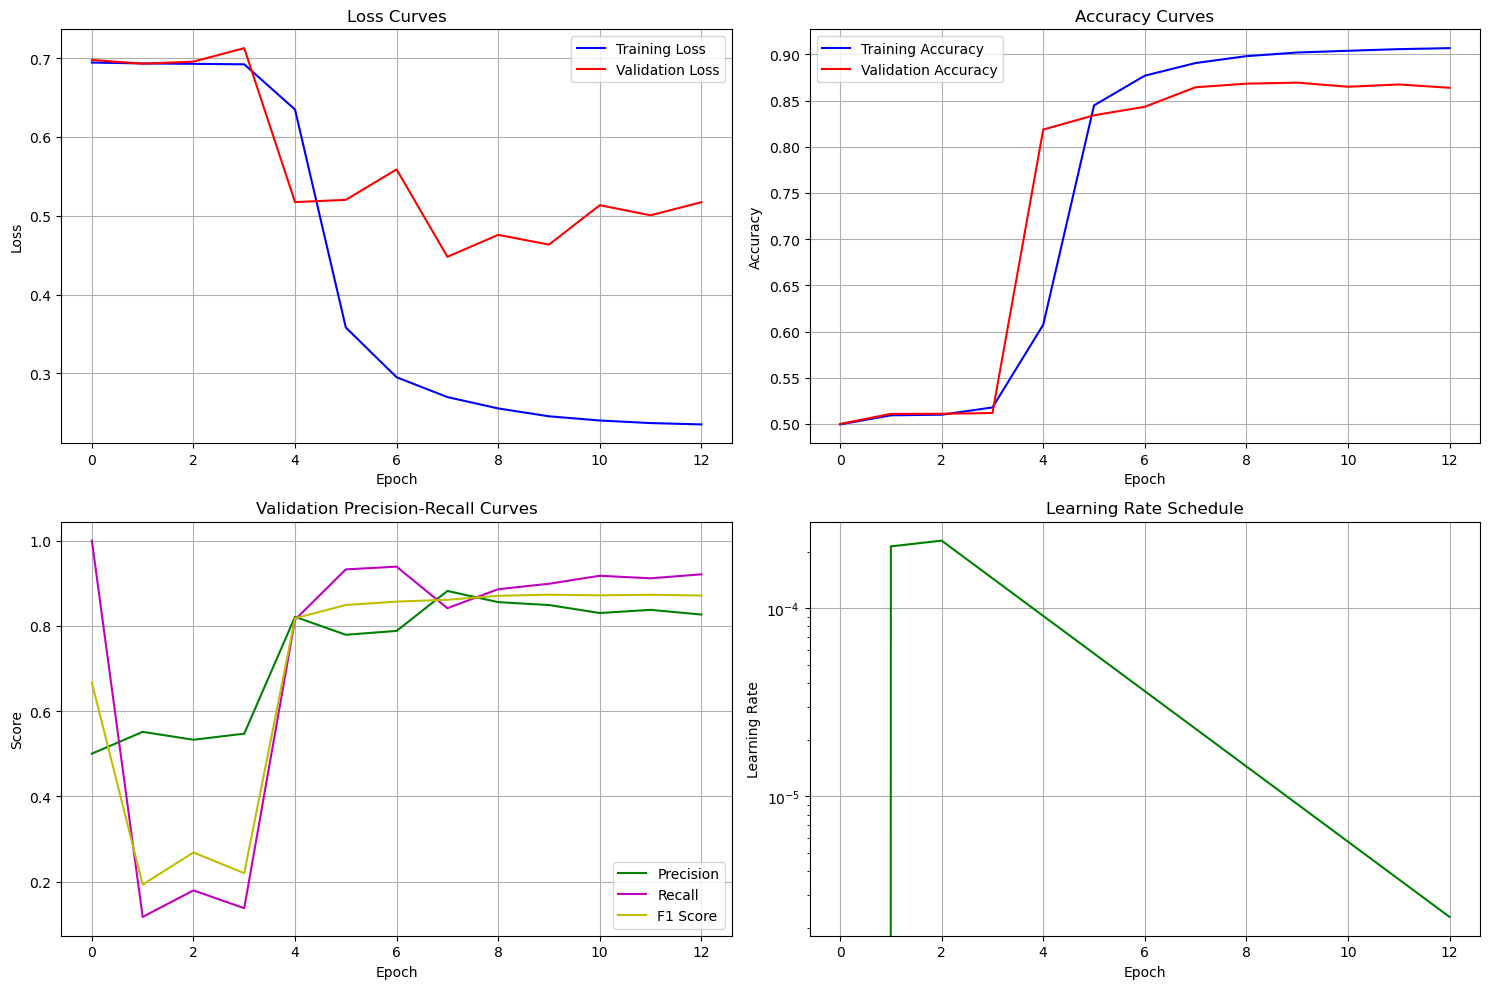

In [18]:
# Plot results
plot_training_curves(metrics, save_path="transformer_metrics.png")

In [19]:
# Save final model and vocabulary
save_model(params, filepath="transformer_imdb_final.pkl")
save_vocab(vocab, filepath="transformer_vocab.pkl")
